In [42]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import statistics
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from statsmodels.multivariate import manova
import scipy.stats as stats
import missingno as msno
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import Lasso

# Mesure de l'hétéroscedasticité
import statsmodels.api as sm
import statsmodels.stats.api as sms

import warnings

dataset = pd.read_csv("sets/train.csv")
df = dataset.copy()

pd.set_option("display.float_format", "{:.2f}".format)
warnings.filterwarnings("ignore")

# **Exploratory Data Analysis (EDA)**
## **1. Checklist de base**
## - Basic Exploration :
- ### Variable target :
  - Type : `df[target].dtypes` : int64 (multiclasse)
  - Distribution des classes : 7 classes complétement équilibré
  - Résumé statistique : `df[target].describe()` :
    - count   15120.00
    - mean        4.00
    - std         2.00
    - min         1.00
    - 25%         2.00
    - 50%         4.00
    - 75%         6.00
    - max         7.00


In [43]:
print(df.head(2))

   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm  ...  Soil_Type32  \
0            221             232            148  ...            0   
1            220             235            151  ...            0   

   Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
0            0            0            0            0            0   
1            0            0            0            0            0   

   Soil_Type38  Soil_Type39  Soil_Type40  Cover_Type  
0            0            0            0           5  
1            0            0            0           5

In [44]:
print(df["Cover_Type"].value_counts())

Cover_Type
5    2160
2    2160
1    2160
7    2160
3    2160
6    2160
4    2160
Name: count, dtype: int64


In [45]:
print(df["Cover_Type"].describe())

count   15120.00
mean        4.00
std         2.00
min         1.00
25%         2.00
50%         4.00
75%         6.00
max         7.00
Name: Cover_Type, dtype: float64


- ### Lignes et colonnes :
  - Nombre de lignes et de colonnes : `df.shape` : (15120, 56)
  - Données uniques / redondantes : `df.columns.duplicated()` : aucune duplication


In [46]:
print(df.shape)
print(df.columns.duplicated())

(15120, 56)
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False]


- ### Types de variables :
  - Catégorielles : 45
  - Continues : 9
  - Dates / Temps : 0

In [47]:
print(df.columns)
print(df["Hillshade_3pm"].head())

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

- ### Analyse de valeurs manquantes (heatmap) :
  - Proportions par colonnes : 0
  - Méthodes de gestion :     
    - Supression :     
    - Imputation :    


Id                                   0.00
Elevation                            0.00
Aspect                               0.00
Slope                                0.00
Horizontal_Distance_To_Hydrology     0.00
Vertical_Distance_To_Hydrology       0.00
Horizontal_Distance_To_Roadways      0.00
Hillshade_9am                        0.00
Hillshade_Noon                       0.00
Hillshade_3pm                        0.00
Horizontal_Distance_To_Fire_Points   0.00
Wilderness_Area1                     0.00
Wilderness_Area2                     0.00
Wilderness_Area3                     0.00
Wilderness_Area4                     0.00
Soil_Type1                           0.00
Soil_Type2                           0.00
Soil_Type3                           0.00
Soil_Type4                           0.00
Soil_Type5                           0.00
Soil_Type6                           0.00
Soil_Type7                           0.00
Soil_Type8                           0.00
Soil_Type9                        

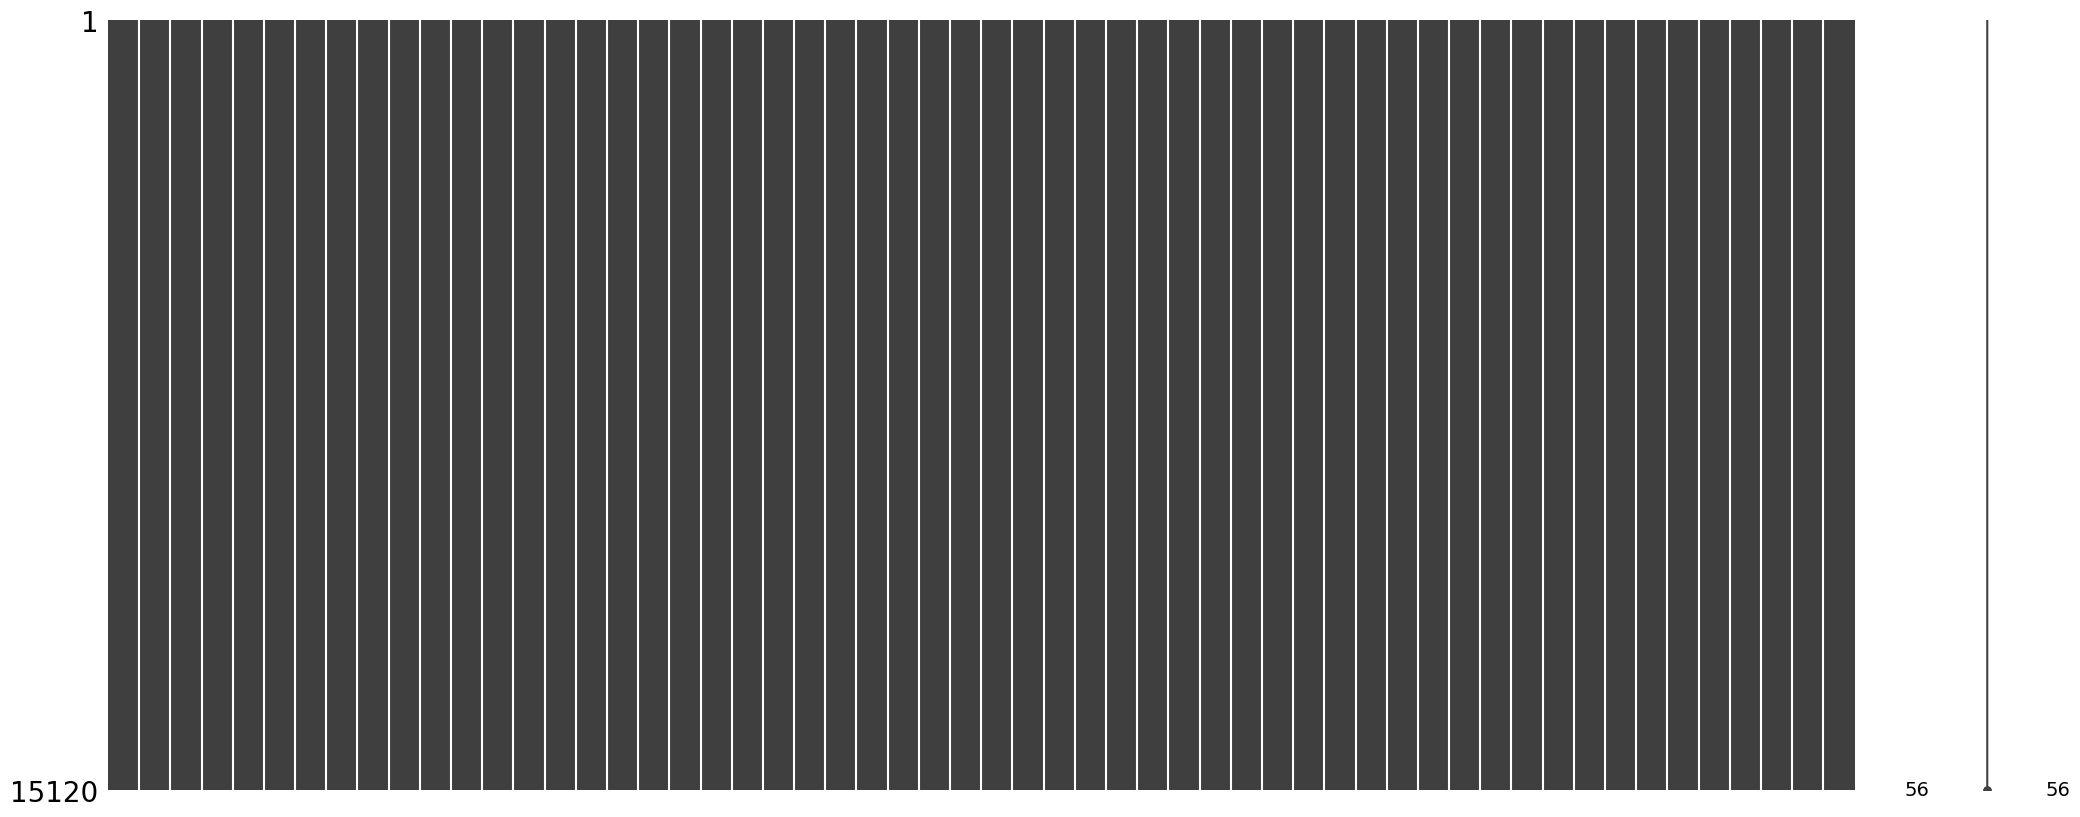

In [48]:
msno.matrix(df)
nan_value = df.isna().sum()/df.shape[0]
print(nan_value)

- ### Analyse des outliers (IQR, Z-score, boxplot) :
  - Proportions par colonnes (IQR) :
    - Slope : 39 : 0.0025793650793650793
    - Horizontal_Distance_To_Hydrology : 285 : 0.018849206349206348
    - Vertical_Distance_To_Hydrology : 213 : 0.014087301587301588
    - Horizontal_Distance_To_Roadways : 155 : 0.0102513227513227
  - Observations : 
    - l'isolation forest ne détecte aucun outliers
    - environ 500 outliers avec le Z-score, cohérent avec l'IQR et le boxplot
  - Méthodes de gestion :
    - Supression : outliers extrème de 'Horizontal_Distance_To_Hydrology'
    - Imputation : possible imputation des légers outliers de 'Horizontal_Distance_To_Hydrology'


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Elevation'),
  Text(1, 0, 'Aspect'),
  Text(2, 0, 'Slope'),
  Text(3, 0, 'Horizontal_Distance_To_Hydrology'),
  Text(4, 0, 'Vertical_Distance_To_Hydrology'),
  Text(5, 0, 'Horizontal_Distance_To_Roadways'),
  Text(6, 0, 'Horizontal_Distance_To_Fire_Points')])

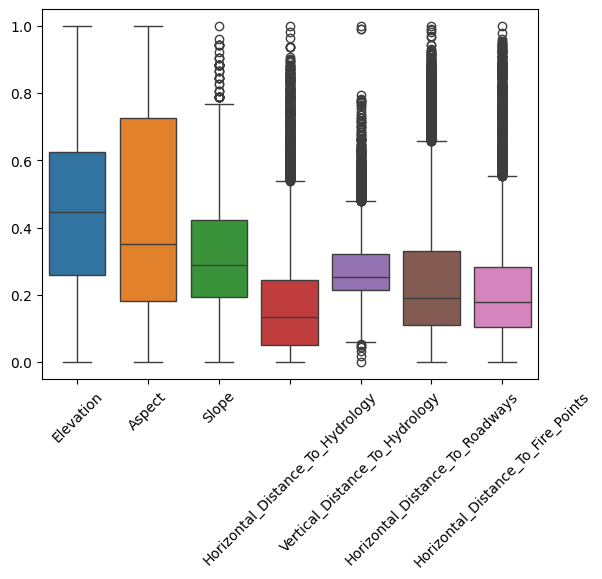

In [49]:
continuous_features = ["Elevation", "Aspect", "Slope", "Horizontal_Distance_To_Hydrology", "Vertical_Distance_To_Hydrology", 
                       "Horizontal_Distance_To_Roadways", "Horizontal_Distance_To_Fire_Points"]
categorial_features = df.drop(continuous_features, axis=1).columns
scaled_df = pd.DataFrame(MinMaxScaler().fit_transform(df[continuous_features]), columns=continuous_features)
sns.boxplot(scaled_df[continuous_features])
plt.xticks(rotation=45)

In [50]:
def outlier_detection(df):
    anomalies = []

    # limite supérieur et inféfieur à 3 écarts-types
    data_std = statistics.stdev(df)
    data_mean = statistics.mean(df)
    anomaly_cut_off = data_std * 3

    lower_limit = data_mean - anomaly_cut_off
    upper_limit = data_mean + anomaly_cut_off

    for outlier in df:
        if outlier < lower_limit or outlier > upper_limit:
            anomalies.append(outlier)
    return anomalies

n_outliers = 0
for col in continuous_features:
    outliers = outlier_detection(df[col])
    print(f"{col} : {len(outliers)} : {len(outliers)/df.shape[0]}")
    n_outliers += len(outliers)

print(f"Nombres d'outliers : {n_outliers} : {n_outliers/df.shape[0]}")

Elevation : 0 : 0.0
Aspect : 0 : 0.0
Slope : 39 : 0.0025793650793650793
Horizontal_Distance_To_Hydrology : 285 : 0.018849206349206348
Vertical_Distance_To_Hydrology : 213 : 0.014087301587301588
Horizontal_Distance_To_Roadways : 155 : 0.01025132275132275
Horizontal_Distance_To_Fire_Points : 331 : 0.021891534391534392
Nombres d'outliers : 1023 : 0.06765873015873015


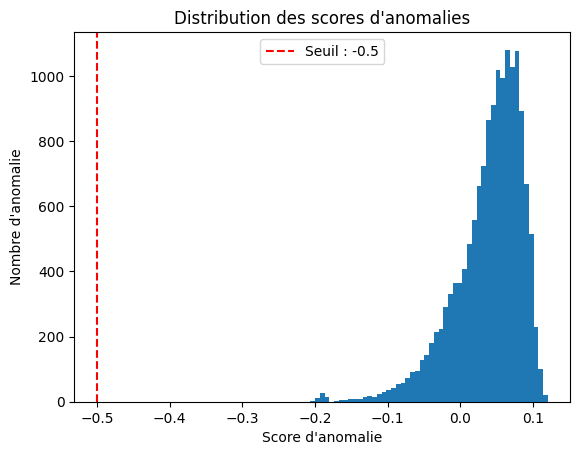

In [51]:
model = IsolationForest(random_state=0, contamination='auto')
model.fit(scaled_df)
outliers_predict = model.predict(scaled_df) == -1
anomaly_score = model.decision_function(scaled_df)

plt.hist(anomaly_score, bins=50)
plt.axvline(x=-0.5, color='red', linestyle='--', label="Seuil : -0.5")
plt.title("Distribution des scores d'anomalies")
plt.xlabel("Score d'anomalie")
plt.ylabel("Nombre d'anomalie")
plt.legend()

In [52]:
z_score = stats.zscore(scaled_df)
outliers = df[(np.abs(z_score) > 3).any(axis=1)]
print("Nombre d'outliers (Z-score > 3) : ", len(outliers))

Nombre d'outliers (Z-score > 3) :  884




---


## - Data Cleaning :    
- ### Renommer les colonnes : `df.rename(function, axis=1, inplace=true)` : `col.replace(a, b)` :  

- ### Supprimer les colonnes inutiles :    

In [53]:
print(df.columns)
df = df.drop("Id", axis=1)

Index(['Id', 'Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points',
       'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_

- ### Fusionner les colonnes redondantes :    

- ### Convertir les types des colonnes :   

In [54]:
df = df.astype({col : "int16" for col in df.columns})
print(df.memory_usage())

Index                                   132
Elevation                             30240
Aspect                                30240
Slope                                 30240
Horizontal_Distance_To_Hydrology      30240
Vertical_Distance_To_Hydrology        30240
Horizontal_Distance_To_Roadways       30240
Hillshade_9am                         30240
Hillshade_Noon                        30240
Hillshade_3pm                         30240
Horizontal_Distance_To_Fire_Points    30240
Wilderness_Area1                      30240
Wilderness_Area2                      30240
Wilderness_Area3                      30240
Wilderness_Area4                      30240
Soil_Type1                            30240
Soil_Type2                            30240
Soil_Type3                            30240
Soil_Type4                            30240
Soil_Type5                            30240
Soil_Type6                            30240
Soil_Type7                            30240
Soil_Type8                      

- ### Gérer les valeurs manquantes :

- ### Gérer les outliers :

In [55]:
outliers = scaled_df[scaled_df["Vertical_Distance_To_Hydrology"] > 0.9]
print(outliers.index)
df = df.drop(outliers.index)

Index([1803, 1892, 11938], dtype='int64')




---


## **2. Exploration Uni-variable**
- ### Variables Continues :
  - Skewness (>0.5 ou <-0.5) : `(décalé)` :  
    - Horizontal_Distance_To_Hydrology   1.49
    - Vertical_Distance_To_Hydrology     1.46
    - Horizontal_Distance_To_Roadways    1.25
    - Horizontal_Distance_To_Roadways    1.25
    - Slope                              0.52
  - Kurtosis (>5 ou ou <1) : `(forme applatie/pointue)` :
    - Slope                              -0.24
    - Elevation                          -1.08
    - Aspect                             -1.15
  - Variance (cv>1.5 ou <0.1):
    - Elevation                          0.15
  - Normalité (p-value < 0.05) :
    - toutes les variables suivent une distributions anormales
  - Homoscedasticité (Breusch-Pagan >0.05):
    - target catégorielle
  - Observations : 
    - les 'Distance_To_Hydrology' ont une grande proportion de valeurs = 0
    - les 'Distance' possèdent certains outliers au delà de la moustache supérieur (Q3 + 1.5 * IQR)
    - classification impossible avec MNLogit, multicolinéarité ?
    - transformations mathématique et encodage nécessaire pour les problèmes de skewness et kurtosis

In [56]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- Statistiques de base (skew, kurt, var, std, range) : 

In [57]:
skewness = df[continuous_features].skew().sort_values(ascending=False)
kurtosis = df[continuous_features].kurt().sort_values(ascending=False)
standard_deviation = df[continuous_features].std().sort_values(ascending=False)
variance_coefficient = standard_deviation / df[continuous_features].mean().sort_values(ascending=False)
print("kurtosis : ", kurtosis)
print("variance : ", variance_coefficient)
print("standard_deviation : ", standard_deviation)

kurtosis :  Horizontal_Distance_To_Fire_Points    3.39
Horizontal_Distance_To_Hydrology      2.81
Vertical_Distance_To_Hydrology        2.69
Horizontal_Distance_To_Roadways       1.02
Slope                                -0.24
Elevation                            -1.08
Aspect                               -1.15
dtype: float64
variance :  Aspect                               0.70
Elevation                            0.15
Horizontal_Distance_To_Fire_Points   0.73
Horizontal_Distance_To_Hydrology     0.92
Horizontal_Distance_To_Roadways      0.77
Slope                                0.51
Vertical_Distance_To_Hydrology       1.19
dtype: float64
standard_deviation :  Horizontal_Distance_To_Roadways      1325.14
Horizontal_Distance_To_Fire_Points   1099.96
Elevation                             417.71
Horizontal_Distance_To_Hydrology      209.94
Aspect                                110.08
Vertical_Distance_To_Hydrology         60.84
Slope                                   8.45
dtype: float64

- Forme de la distribution (Histogramme, Boxplot, Scatterplot) : 

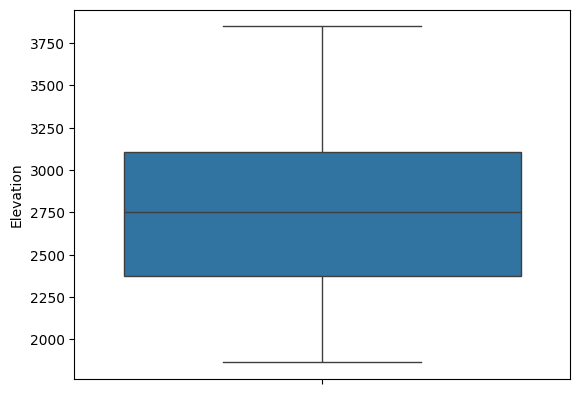

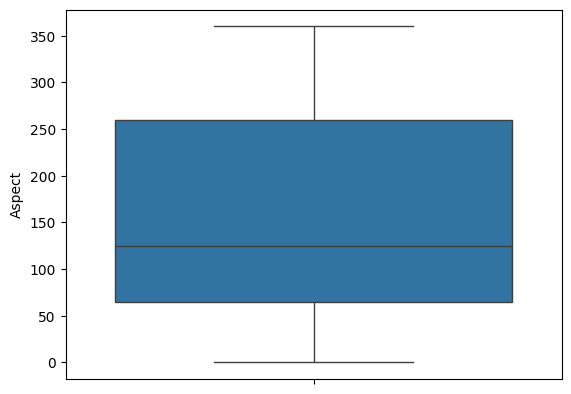

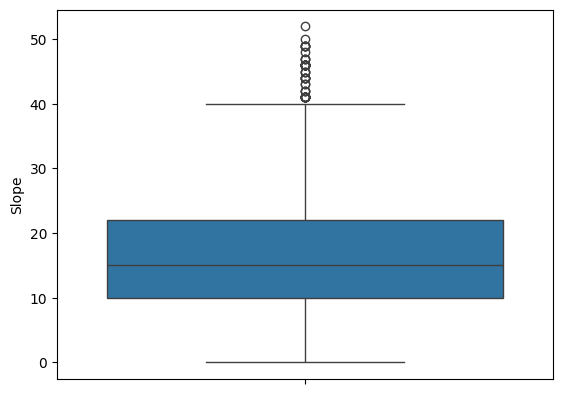

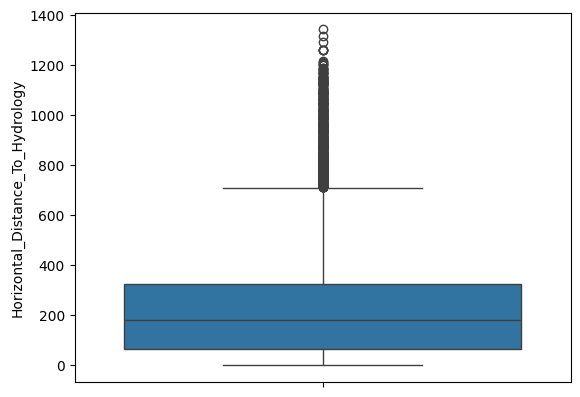

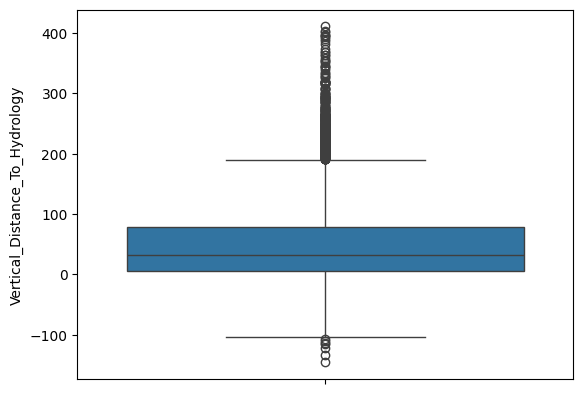

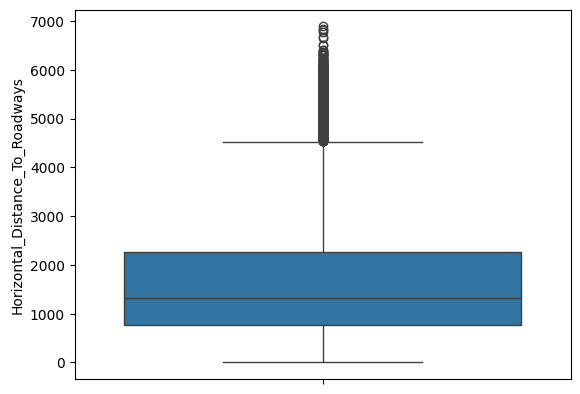

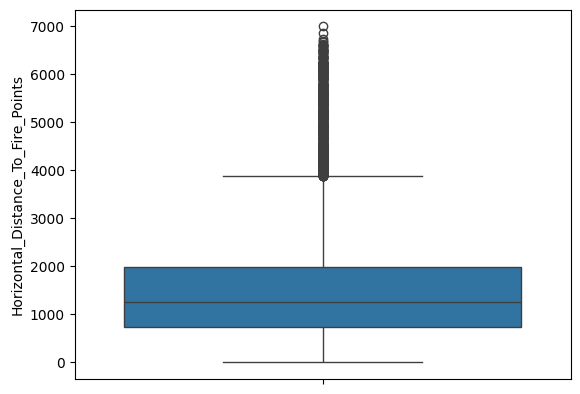

In [58]:
for col in continuous_features:
    plt.figure()
    sns.boxplot(df[col])

In [59]:
print(df[df["Horizontal_Distance_To_Hydrology"] > 650].shape[0])

686


- Normalité (QQPlot, Shapiro-Wilk, Kolmogorov-Smirnov, Lilliefors) : 

In [60]:
for col in continuous_features:
    #plt.figure()
    #stats.probplot(df[col], dist='norm', plot=plt)
    stat, p_value = stats.shapiro(df[col])
    print(f"p_value : {p_value}")

p_value : 5.352454591351093e-50
p_value : 5.009512004627111e-68
p_value : 1.5153756174700023e-46
p_value : 4.729465821803842e-76
p_value : 8.959948007554246e-77
p_value : 1.2871075028045188e-74
p_value : 1.5674878716515788e-76


- Homoscedasticité (Breusch-Pagan, probplot) : 

- ### Variables Catégorielles :
  - Multiclasse : 'Hillshade' et 'Cover_Type'
  - Binaire : 'Wilderness_Area' et 'Soil_Type'
  - Catégories dominantes :
    - Hillshade_9am : augmente progressivement jusqu'à environ 220/255 (pic) puis diminue
    - Hillshade_Noon : similaire à 'Hillshade_9am'
    - Hillshade_3pm : idem mais pic vers 150/255
    - 'Wilderness_Area1' et 'Wilderness_Area2' : classe 0 très dominante
    - 'Wilderness_Area4' : classe 0 dominante (x2)
    - 'Soil_Type' : classe 0 LARGEMENT dominante
  - Observations : 
    - 'Soil_Type7' et 15 n'ont qu'une seule classe : inutile
    - les 'Hillshade' pourrait être corrélé, ils ont un pic à des classes différentes, mais le paterne reste le même
    - les 'Soil_Type' devront sûrement tous être supprimé, dû au déséquilibre extrême

In [61]:
categorial_features = df.drop(continuous_features, axis=1).columns
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40', 'Cover_Type'],
      dtype='object')


- Statistiques descriptives (fréquence, mode): 

In [62]:
print(df[categorial_features].nunique())

Hillshade_9am       176
Hillshade_Noon      141
Hillshade_3pm       247
Wilderness_Area1      2
Wilderness_Area2      2
Wilderness_Area3      2
Wilderness_Area4      2
Soil_Type1            2
Soil_Type2            2
Soil_Type3            2
Soil_Type4            2
Soil_Type5            2
Soil_Type6            2
Soil_Type7            1
Soil_Type8            2
Soil_Type9            2
Soil_Type10           2
Soil_Type11           2
Soil_Type12           2
Soil_Type13           2
Soil_Type14           2
Soil_Type15           1
Soil_Type16           2
Soil_Type17           2
Soil_Type18           2
Soil_Type19           2
Soil_Type20           2
Soil_Type21           2
Soil_Type22           2
Soil_Type23           2
Soil_Type24           2
Soil_Type25           2
Soil_Type26           2
Soil_Type27           2
Soil_Type28           2
Soil_Type29           2
Soil_Type30           2
Soil_Type31           2
Soil_Type32           2
Soil_Type33           2
Soil_Type34           2
Soil_Type35     

In [63]:
categorial_features = categorial_features.drop(["Soil_Type7", "Soil_Type15"])

In [64]:
print(categorial_features)

Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Distribution des classes (barchat, countplot) : 

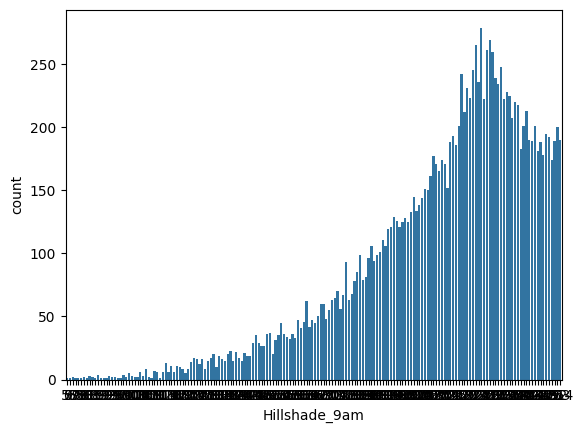

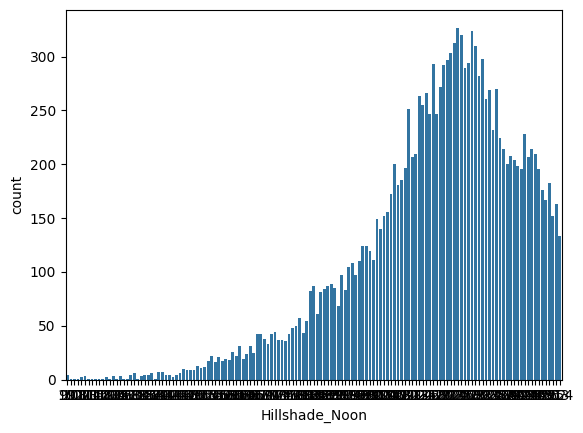

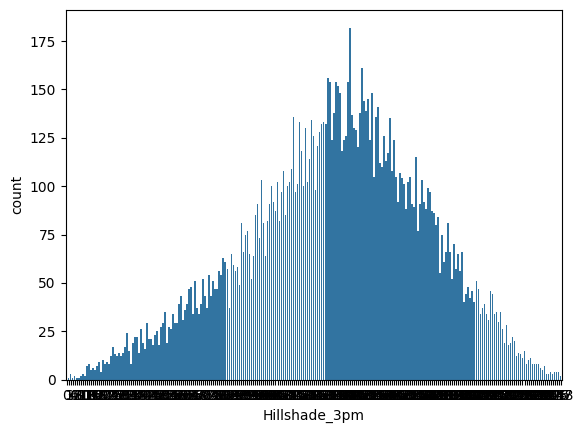

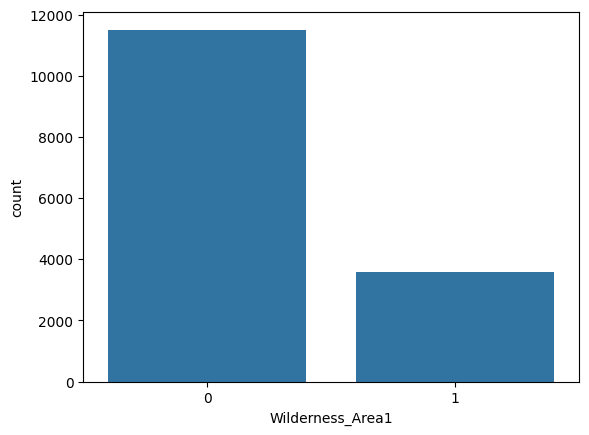

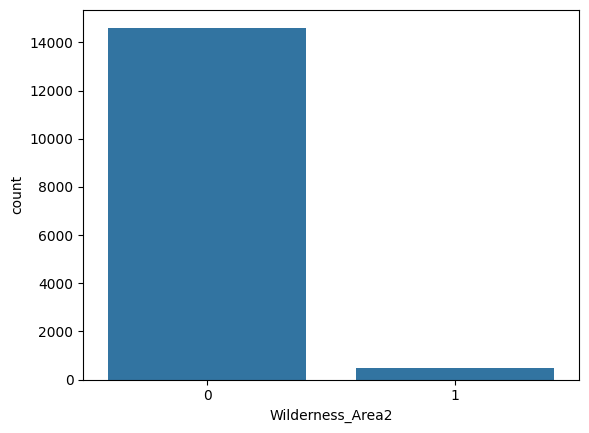

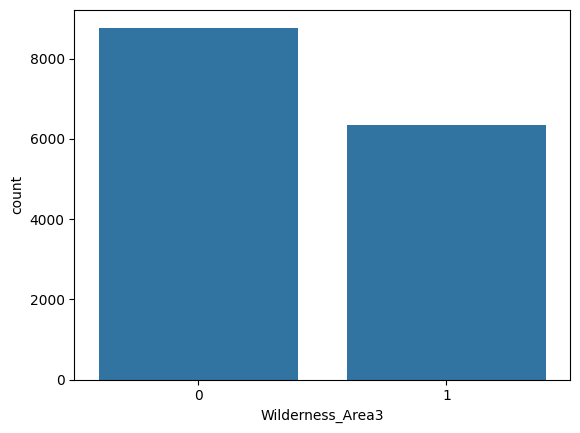

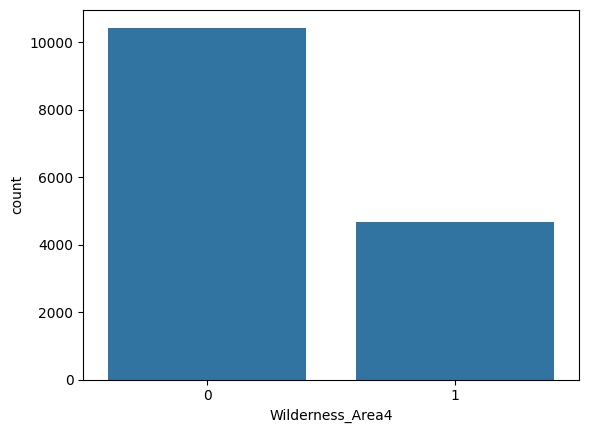

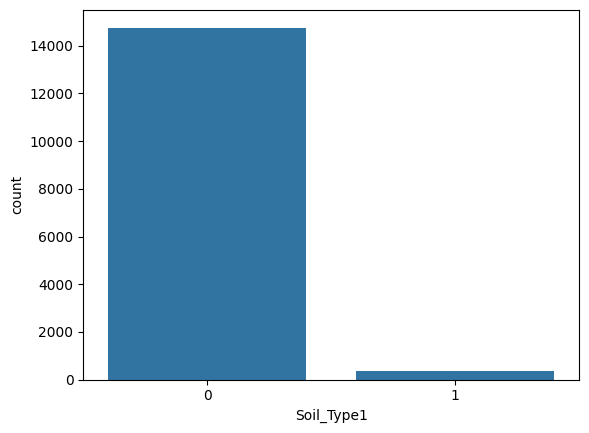

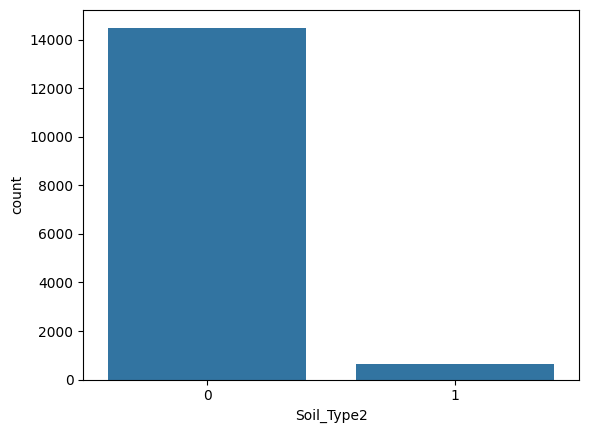

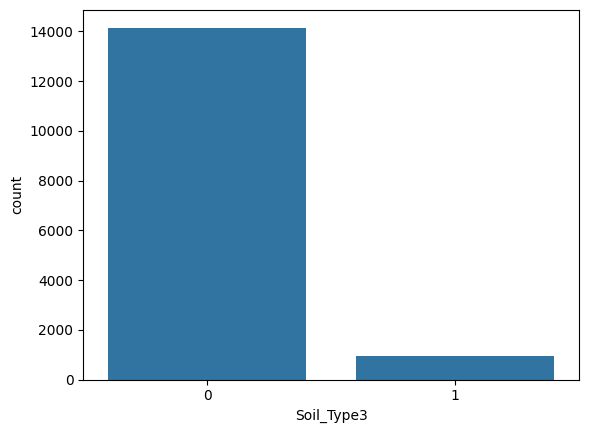

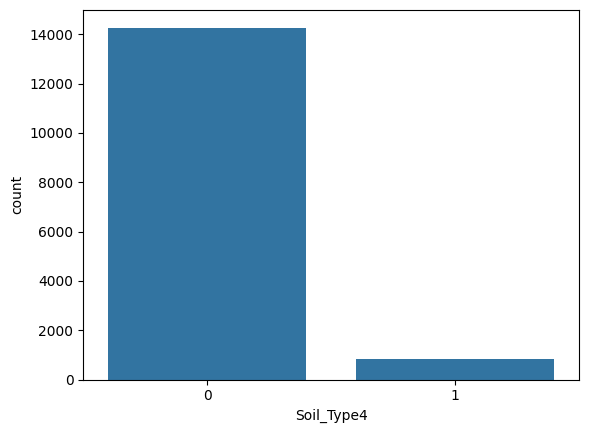

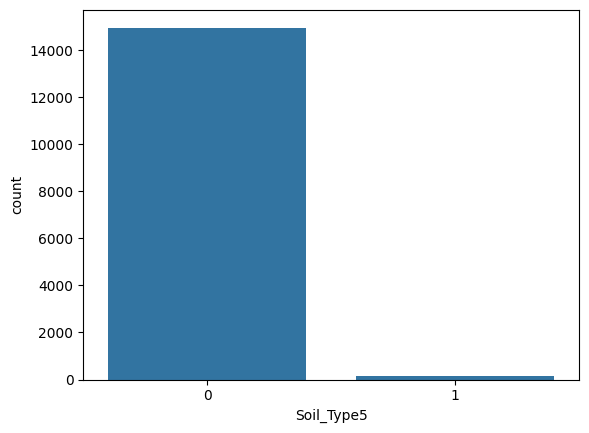

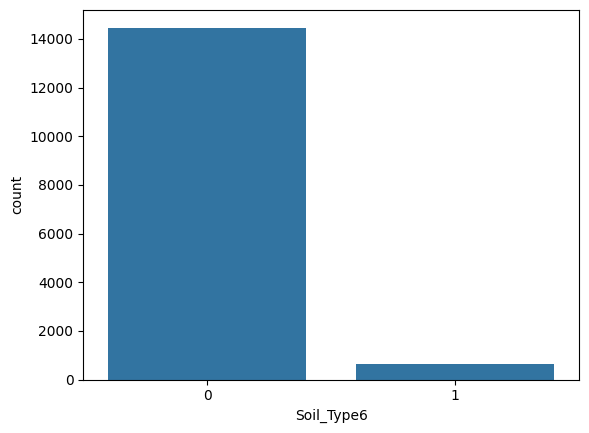

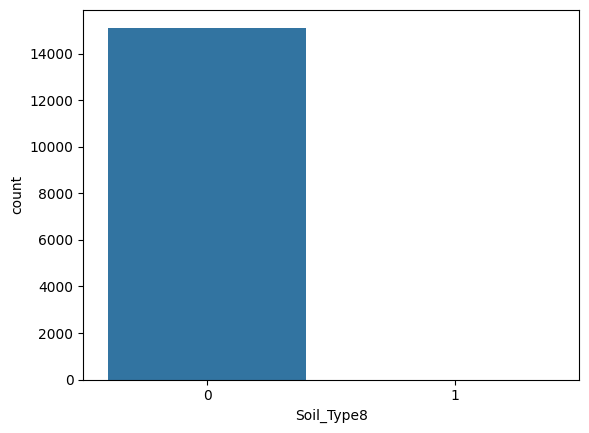

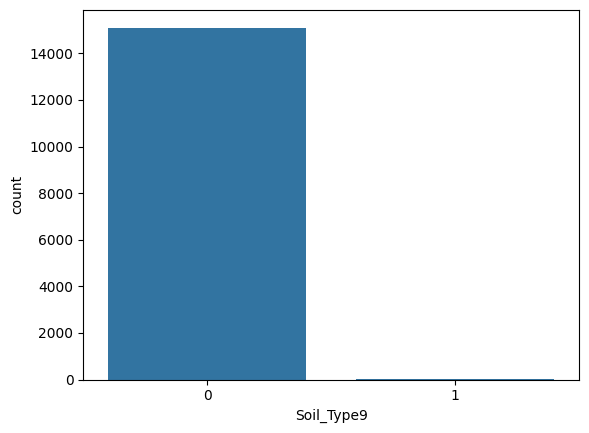

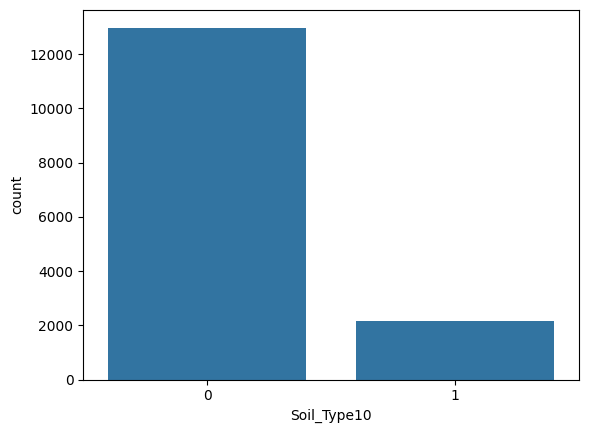

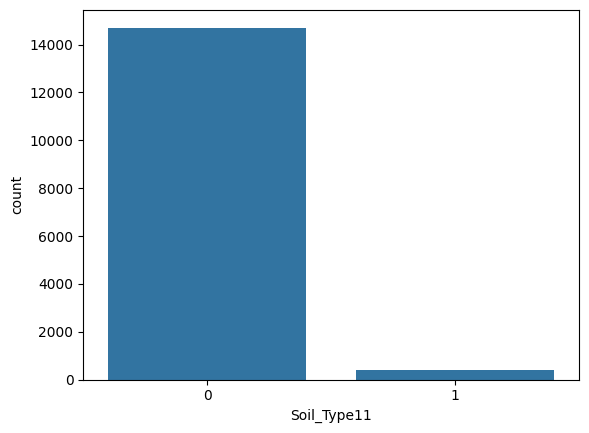

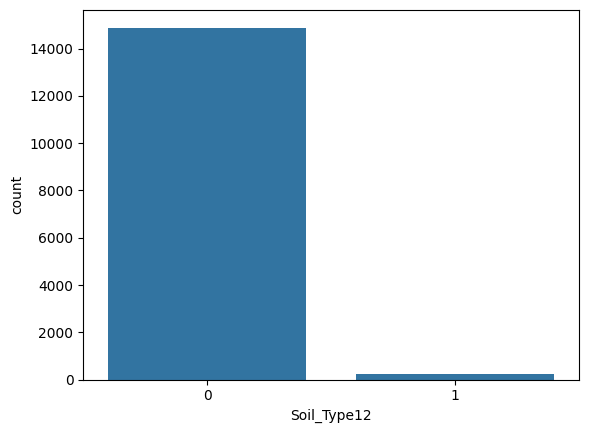

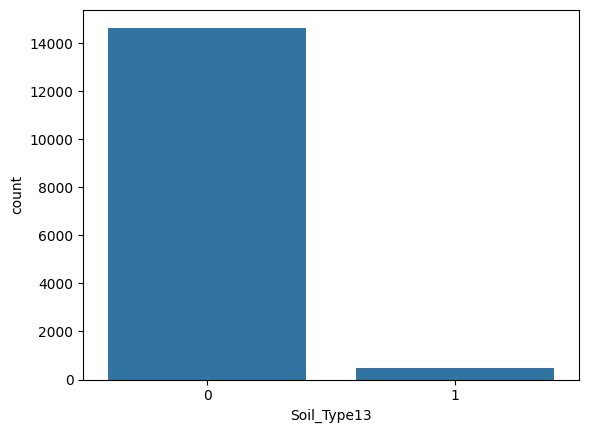

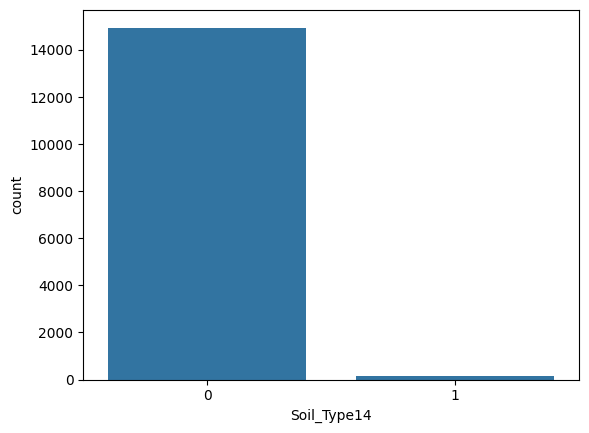

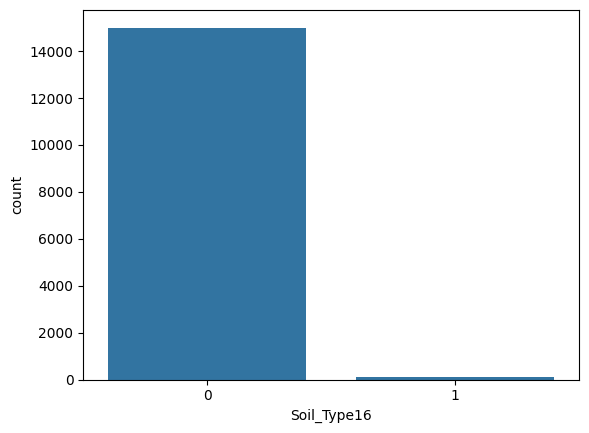

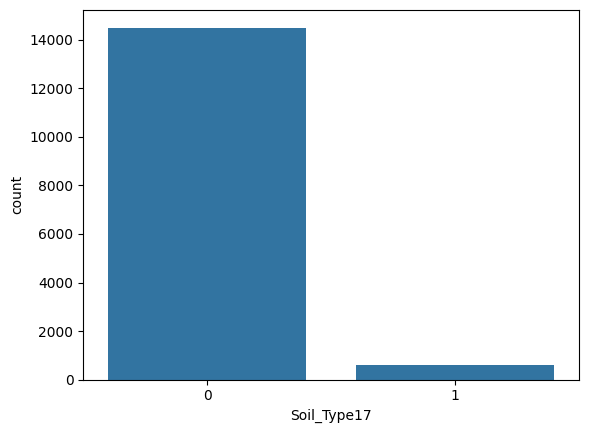

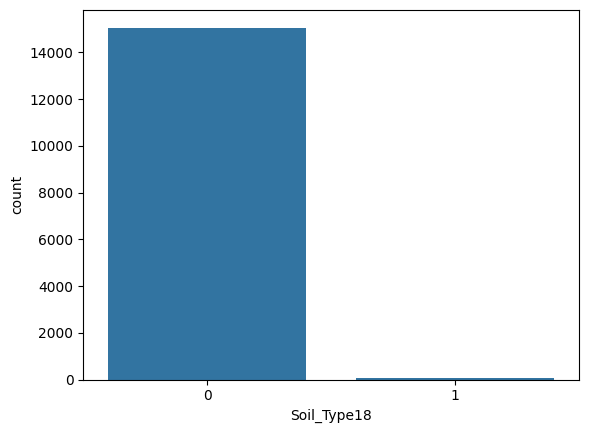

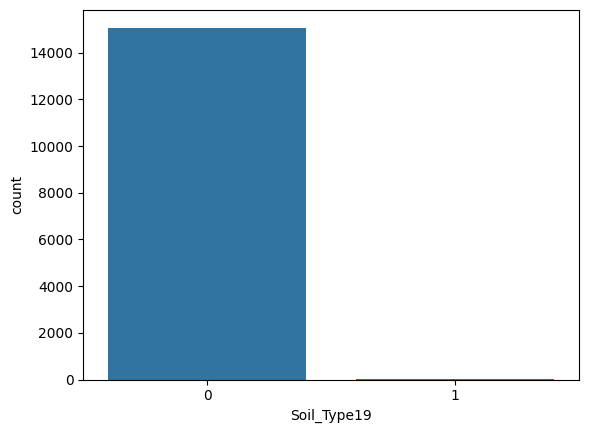

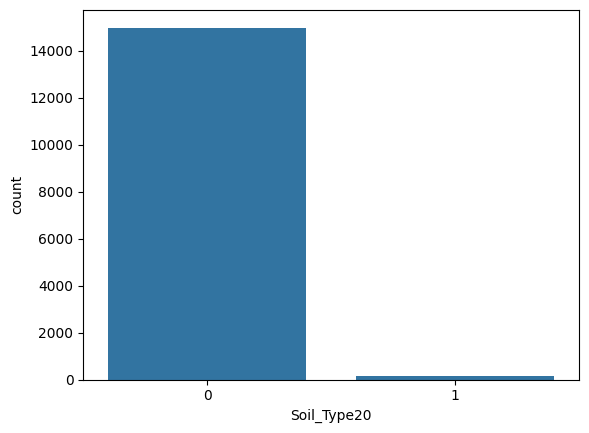

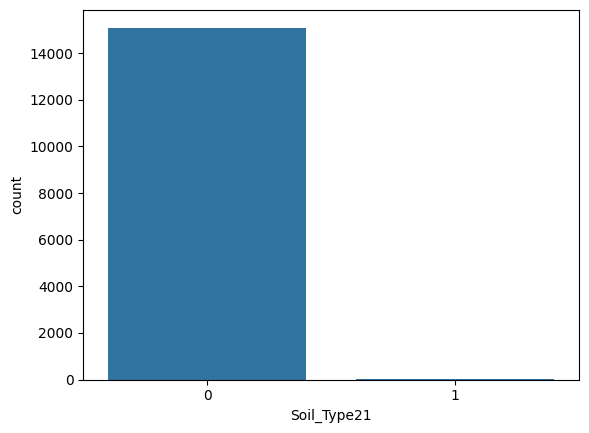

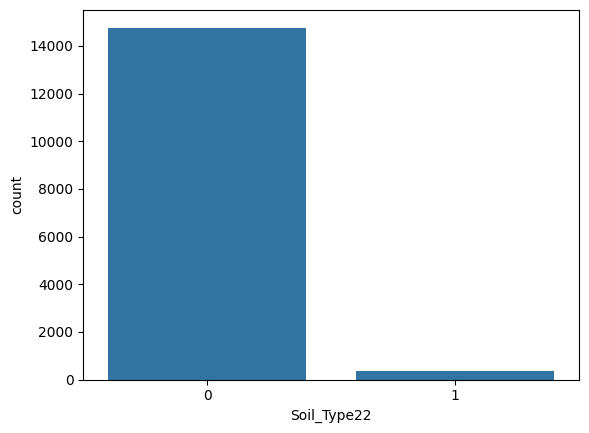

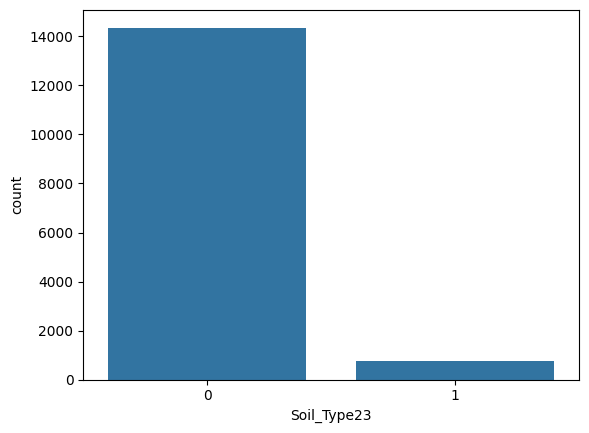

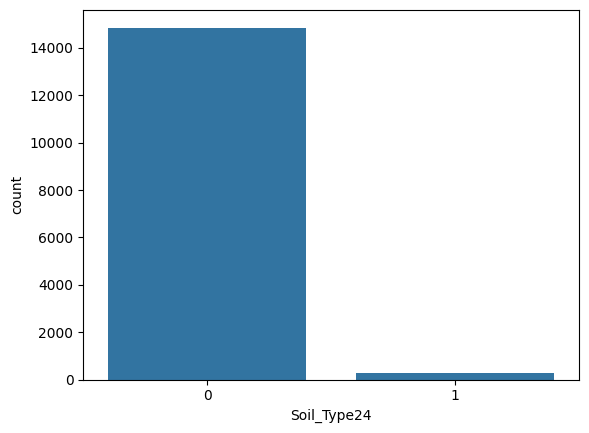

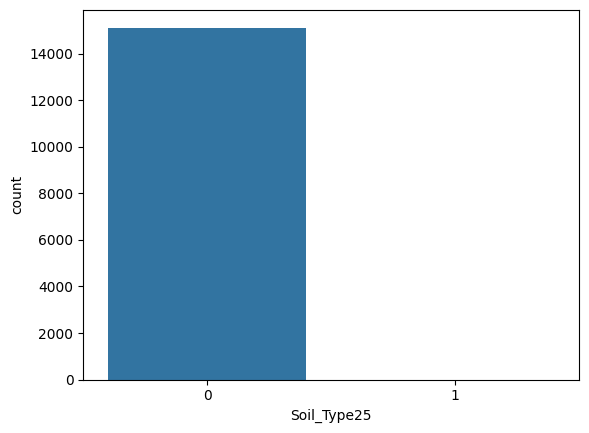

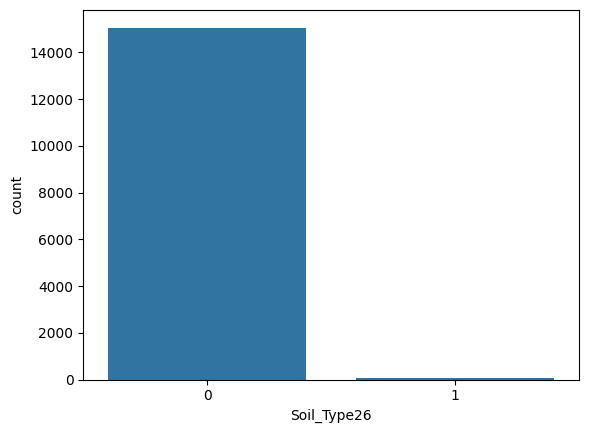

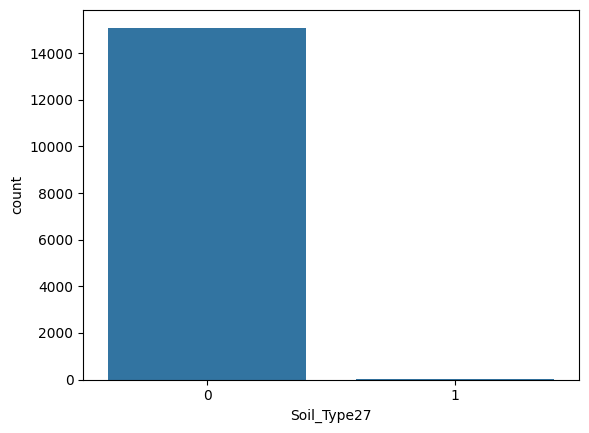

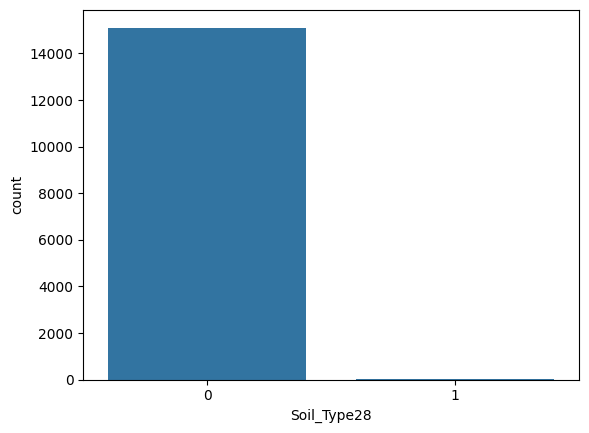

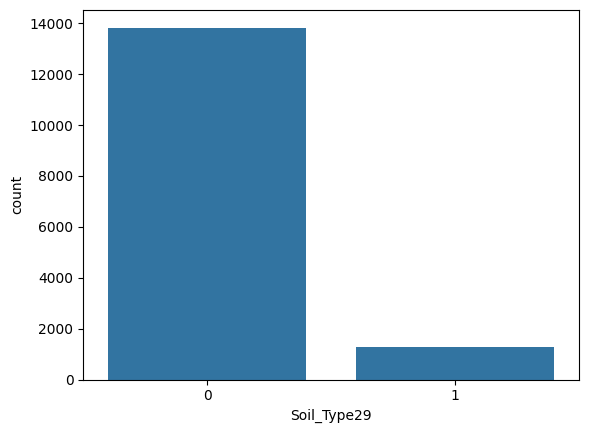

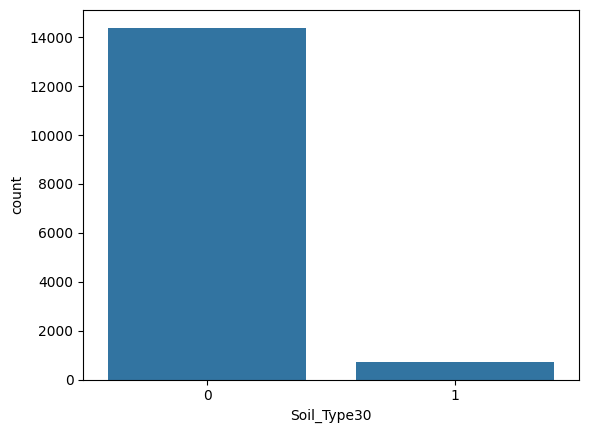

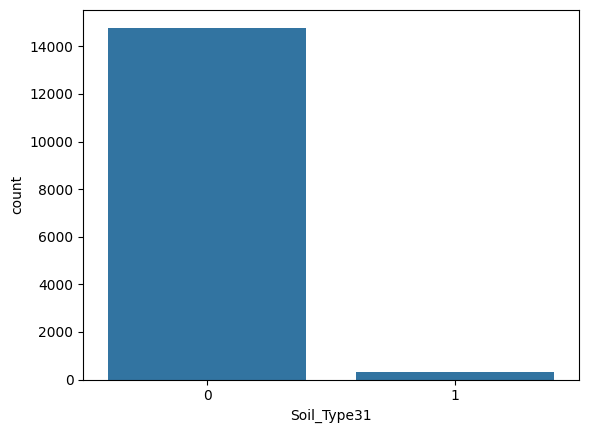

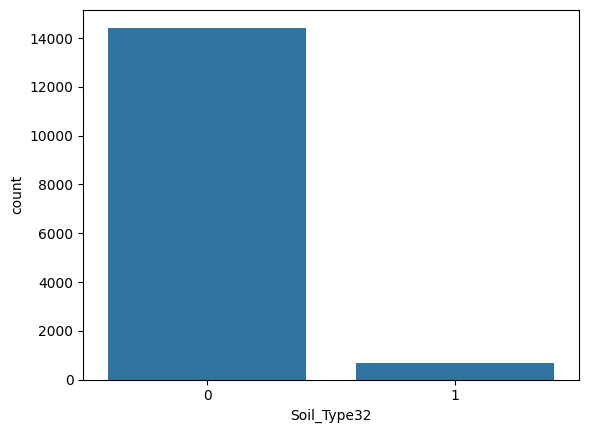

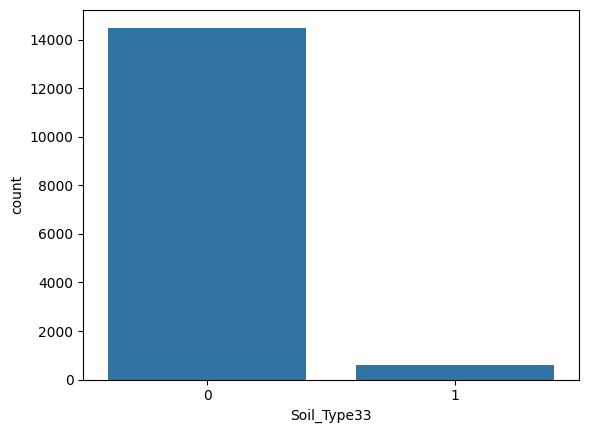

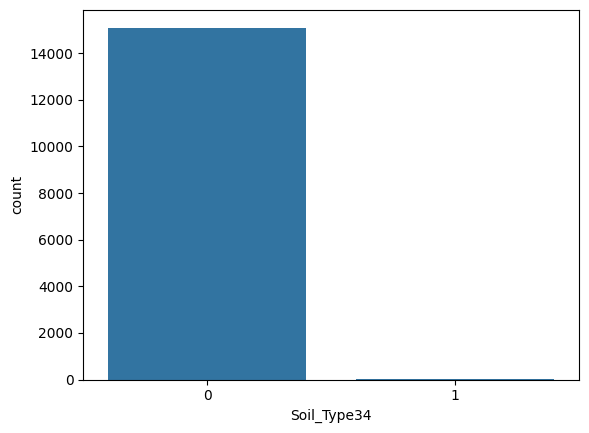

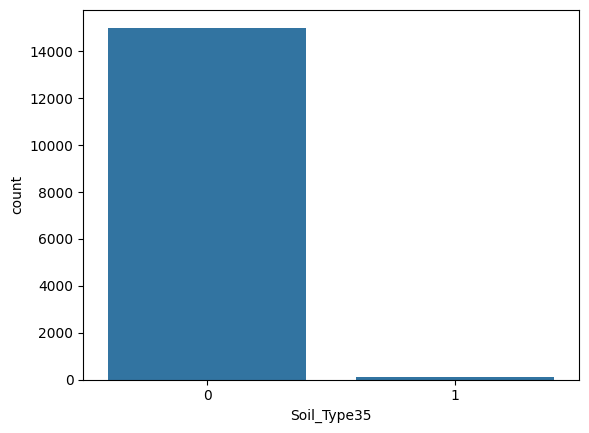

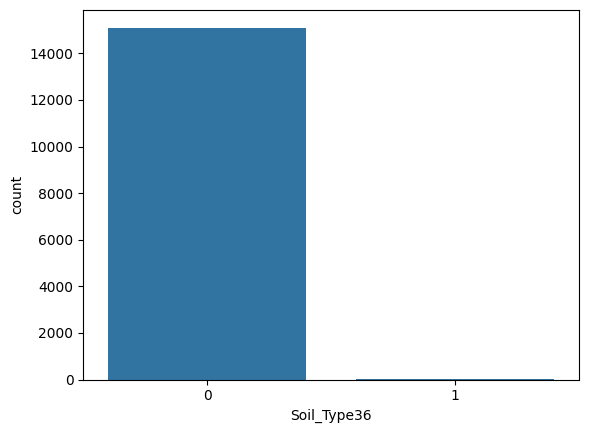

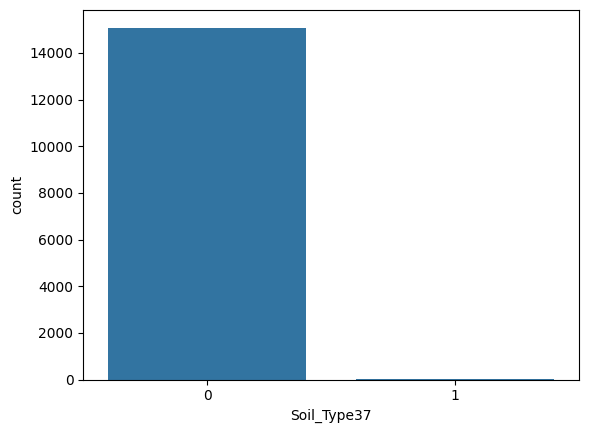

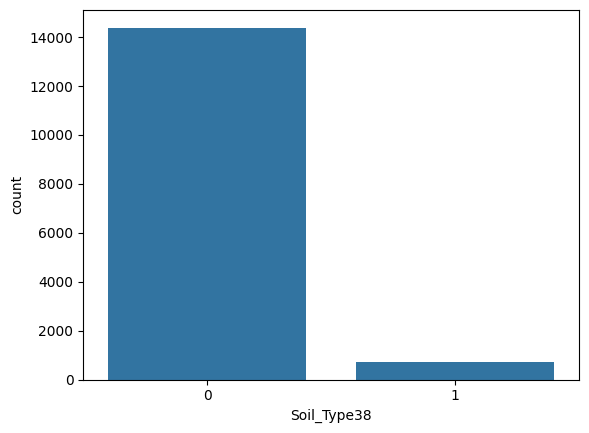

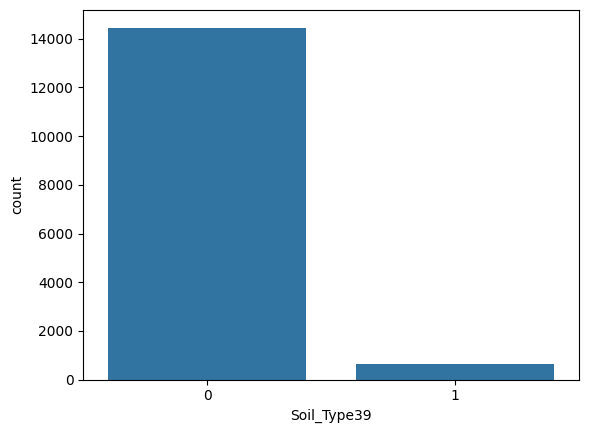

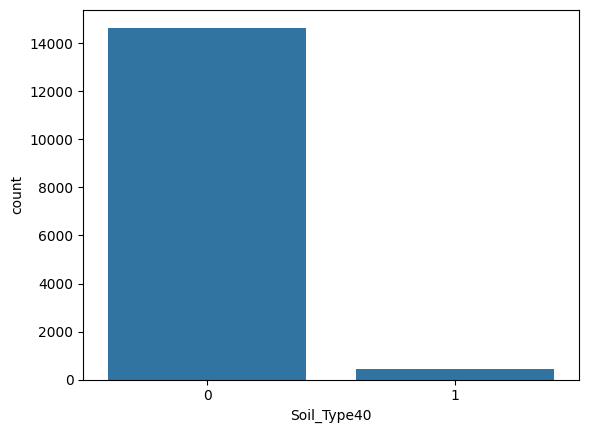

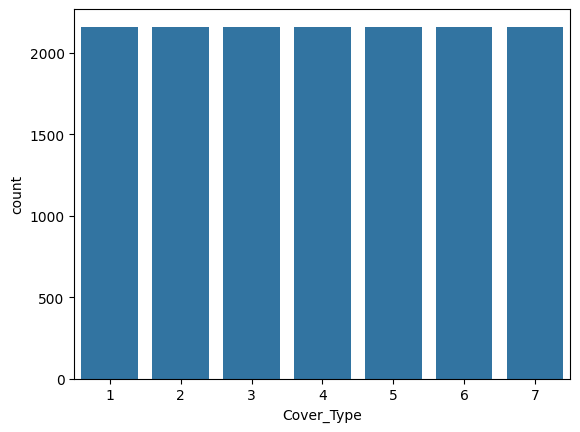

In [65]:
for col in categorial_features:
    plt.figure()
    sns.countplot(x=col, data=df)

## **3. Exploration Bi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation) :
  - Corrélations : 
    - 'Elevation' / 'Horizontal_Distance_To_Hydrology' : 0.41
    - 'Elevation' / 'Horizontal_Distance_To_Roadways' : 0.58
    - 'Elevation' / 'Horizontal_Distance_To_Fire_Points' : 0.44
    - 'Horizontal_Distance_To_Hydrology' / 'Vertical_Distance_To_Hydrology' : 0.65
    - 'Horizontal_Distance_To_Roadways' / 'Horizontal_Distance_To_Fire_Points' : 0.49
    - 'Slope' / 'Elevation' : -0.31
    - 'Slope' / 'Horizontal_Distance_To_Roadways' : -0.28
    - 'Slope' / 'Horizontal_Distance_To_Fire_Points' : -0.24
  - P-value : 
    - 'Horizontal_Distance_To_Roadways' / 'Horizontal_Distance_To_Fire_Points' : P-Value : 0.27
  - Observations :
    - 'Elevation' est corrélé à plusieurs variables, c'est un indice de multicolinéarité
    - les 'Distance_To_Hydrology' semble être relativement dépendante
    - 'Horizontal_Distance_To_Roadways' et 'Horizontal_Distance_To_Hydrology' ont des statistiques descriptives très similaire. Mais la p-value (Spearman) est élevé, la relation monotone pourrait être dû au hasard, car les stats sont similaires.

In [66]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


- Visualisations de corrélations (heatmap, scatterplot) : 

In [67]:
continuous_corr = df[continuous_features].corr()

<Axes: >

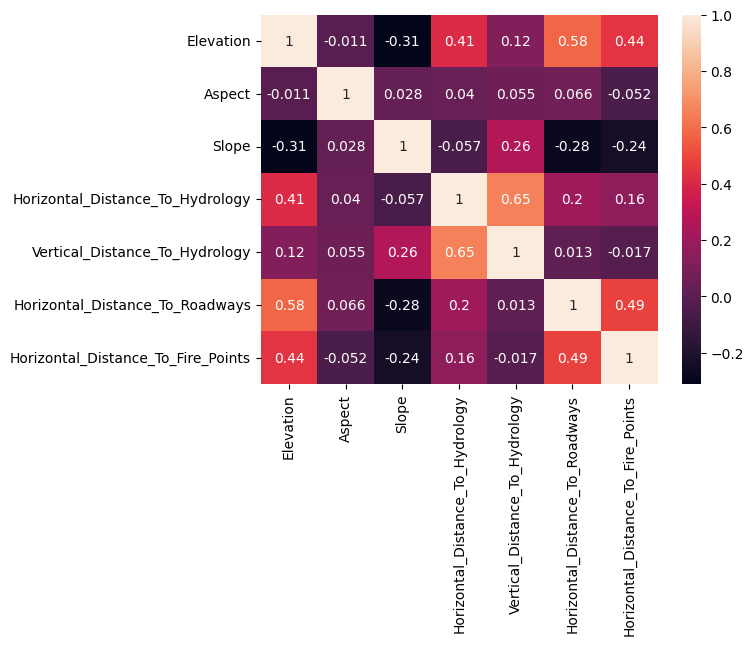

In [68]:
sns.heatmap(continuous_corr, annot=True, cbar=True)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Elevation'),
  Text(1, 0, 'Aspect'),
  Text(2, 0, 'Slope'),
  Text(3, 0, 'Horizontal_Distance_To_Hydrology'),
  Text(4, 0, 'Vertical_Distance_To_Hydrology'),
  Text(5, 0, 'Horizontal_Distance_To_Roadways'),
  Text(6, 0, 'Horizontal_Distance_To_Fire_Points')])

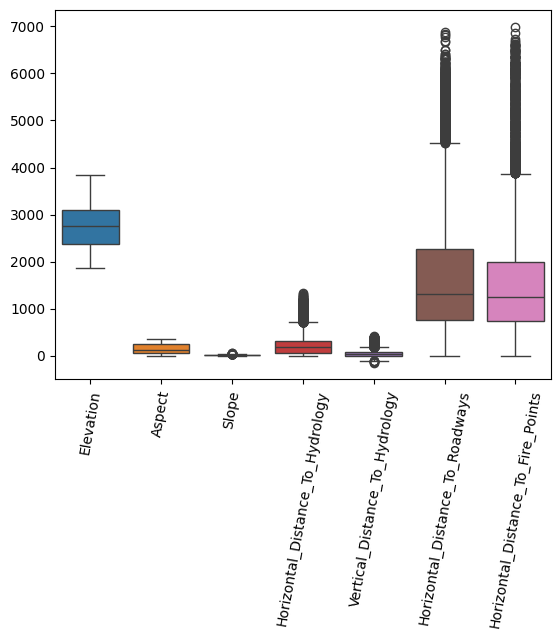

In [69]:
sns.boxplot(df[continuous_features])
plt.xticks(rotation=80)

- Statistiques de corrélations (pearson, spearman, kendall) : 

In [70]:
print(df["Horizontal_Distance_To_Roadways"].describe())
print(df["Horizontal_Distance_To_Fire_Points"].describe())

count   15117.00
mean     1714.19
std      1325.14
min         0.00
25%       764.00
50%      1316.00
75%      2270.00
max      6890.00
Name: Horizontal_Distance_To_Roadways, dtype: float64
count   15117.00
mean     1510.96
std      1099.96
min         0.00
25%       730.00
50%      1256.00
75%      1988.00
max      6993.00
Name: Horizontal_Distance_To_Fire_Points, dtype: float64


In [71]:
spearman_corr, spearman_p_value = stats.spearmanr(df[continuous_features])
spearman_corr_df = pd.DataFrame(spearman_corr, index=continuous_features, columns=continuous_features)
spearman_pval_df = pd.DataFrame(spearman_p_value, index=continuous_features, columns=continuous_features)

print("Correlation Spearman : ", spearman_corr_df)
print("\nP-Value Spearman : ", spearman_pval_df)

Correlation Spearman :                                      Elevation  Aspect  Slope  \
Elevation                                1.00   -0.01  -0.31   
Aspect                                  -0.01    1.00   0.05   
Slope                                   -0.31    0.05   1.00   
Horizontal_Distance_To_Hydrology         0.38    0.03   0.03   
Vertical_Distance_To_Hydrology           0.09    0.07   0.33   
Horizontal_Distance_To_Roadways          0.60    0.07  -0.28   
Horizontal_Distance_To_Fire_Points       0.51   -0.06  -0.24   

                                    Horizontal_Distance_To_Hydrology  \
Elevation                                                       0.38   
Aspect                                                          0.03   
Slope                                                           0.03   
Horizontal_Distance_To_Hydrology                                1.00   
Vertical_Distance_To_Hydrology                                  0.70   
Horizontal_Distance_To_Roadways

- ### Variables Continues et Catégorielles :
  - Corrélations : 
    - Distributions : 
      - Elevation / Wilderness_Area1 et Wilderness_Area2 : plage et densités de valeurs de 'Elevation' très différente entre les classes 0 et 1 des 'Wilderness'
      - Elevation / Wilderness_Area4 : plage de valeur opposé entre classe 0 et 1 de 'Wilderness'
      - Elevation / Cover_Type : plage relativement différente entre les classes, densité similaire entre classe [4, 5, 7], et [1, 2, 3, 6]
      - Slope / Wilderness_Area4 : outliers présent sur la classe 0 uniquement, densité plus grande proche de 0 pour classe 1
      - Horizontal_Distance_To_Roadways / Wilderness_Area1 : densités assez différentes
      - Horizontal_Distance_To_Roadways / Wilderness_Area2 : outliers présent sur classe 0 uniquement
      - Horizontal_Distance_To_Roadways / Wilderness_Area4 : densités et plage de valeurs très différentes entre les 2 classes
      - Horizontal_Distance_To_Roadways / Cover_Type : [1, 2], [3, 4, 5, 6] similaire
      - Horizontal_Distance_To_Fire_Points : idem que 'Horizontal_Distance_To_Roadways'
  - Skewness (>0.5 ou <-0.5) : `(décalé)` : 
    - Elevation / Cover_Type : 5 = -0.62 ; 7 = 1.07
    - Aspect /
      - Wilderness_Area1 : 1 = 1.01
      - Wilderness_Area3 : 0 = 0.56
      - Wilderness_Area4 : 0 = 0.52
      - Cover_Type : 4 = 1.02 ; 5 = 0.81
    - Slope / Cover_Type et Wilderness_Area : toutes les classes sont asymétriques
    - Distance / Cover_Type et Wilderness_Area : toutes les classes sont asymétriques
  - Variance (cv >1) :
    - Slope / Cover_Type (classe 4) : 1.37
    - Vertical_Distance_To_Hydrology / 
      - Wilderness_Area1 : 0 = 1.15 ; 1 =1.34
      - Wilderness_Area2 : 0 = 1.19 ; 1 = 1.24
      - Wilderness_Area3 : 0 = 1.20 ; 1 = 1.18
      - Wilderness_Area4 : 0 = 1.24 ; 1 = 1.09
      - Cover_Type : 1 = 1.35 ; 2 = 1.20 ; 4 = 1.45 ; 5 = 1.15 ; 6 = 1.05 ; 7 = 1.17
  - Observations :
    - les similitudes de corrélations (continue - catégorielle) entre 'To_Roadways' et 'To_Fire_Points' sont très similaire, possible redondance des données
    - toues les features "Distance" semble avoir une forte asymétrie, seules ou accompagné de features catégorielles
    

In [72]:
print(continuous_features)
#categorial_features = categorial_features.drop([col for col in categorial_features if 'Soil_Type' in col])
print(categorial_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
Index(['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40',
       'Cover_Type'],
      dtype='object')


- Visualisations de corrélations (boxplot, violonplot, barplot) : 

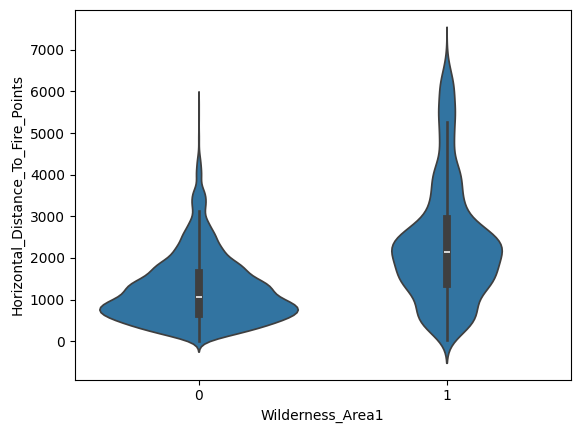

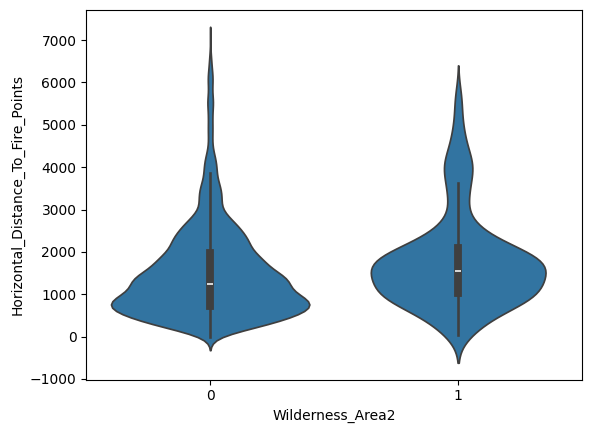

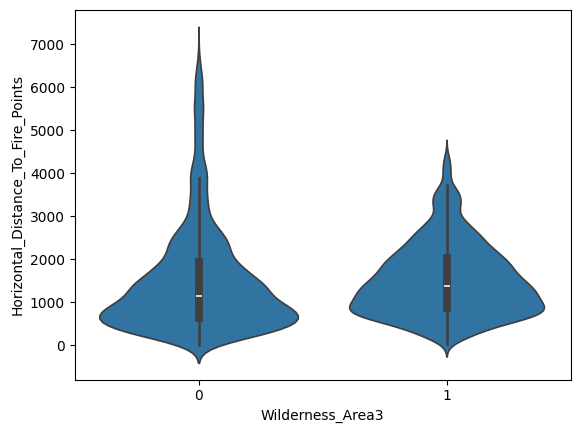

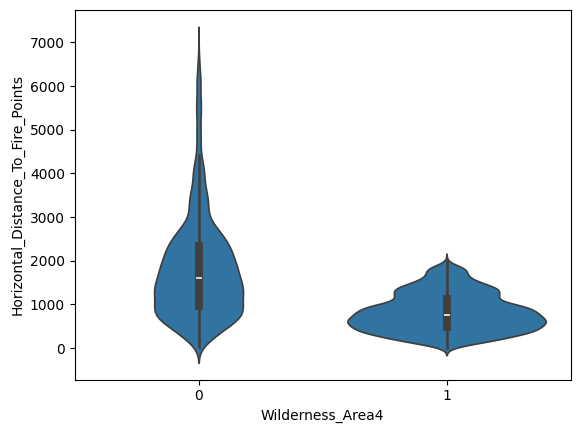

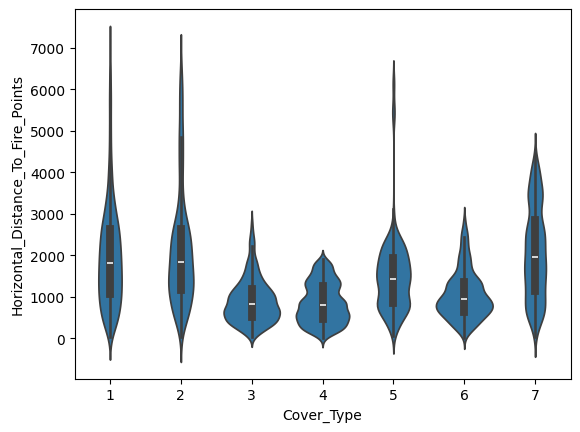

In [79]:
for col in [col for col in categorial_features if "Hillshade" not in col and "Soil_Type" not in col]:
    plt.figure()
    sns.violinplot(x=df[col], y=df["Horizontal_Distance_To_Fire_Points"])

- Statistiques de bases (mean, skew, var) : 

In [83]:
print(continuous_features)

['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']


In [113]:
for col in [col for col in categorial_features if "Hillshade" not in col and "Soil_Type" not in col]:
    groupby = df.groupby(col)["Vertical_Distance_To_Hydrology"]
    skew = groupby.skew()
    skew = skew[(skew >= 0.5) | (skew <= -0.5)]
    print(skew)

Wilderness_Area1
0   1.40
1   1.61
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area2
0   1.50
1   0.80
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area3
0   1.23
1   1.61
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area4
0   1.63
1   1.05
Name: Vertical_Distance_To_Hydrology, dtype: float64
Cover_Type
1   1.80
2   1.68
3   0.87
4   1.42
5   1.04
6   1.05
7   1.40
Name: Vertical_Distance_To_Hydrology, dtype: float64


In [112]:
for col in [col for col in categorial_features if "Hillshade" not in col and "Soil_Type" not in col]:
    groupby = df.groupby(col)["Vertical_Distance_To_Hydrology"]
    coef_var = groupby.std() / groupby.mean()
    for value in coef_var:
        if value >= 1:
            print(coef_var)
            break

Wilderness_Area1
0   1.15
1   1.34
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area2
0   1.19
1   1.24
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area3
0   1.20
1   1.18
Name: Vertical_Distance_To_Hydrology, dtype: float64
Wilderness_Area4
0   1.24
1   1.09
Name: Vertical_Distance_To_Hydrology, dtype: float64
Cover_Type
1   1.35
2   1.20
3   0.91
4   1.45
5   1.15
6   1.05
7   1.17
Name: Vertical_Distance_To_Hydrology, dtype: float64


- Statistiques de relations (t de Student, ANOVA, Kruskal-Wallis, CDF, point-biserial) : 

- ### Variables Catégorielles (heatmap, cramer's-v, PMF, CDF) :
  - Corrélations : 
  - Observations :

- Visualisations de corrélations (boxplot, violongplot, barplot) : 

- Stastiques de corrélations (Cramér's V, chi2, fisher, kendall) : 

- Statistiques de probabilités (CDF, PMF) : 



---


## **4. Exploration Multi-variable**
- ### Variables Continues (scatterplot, matrice de corrélation, régression/classification) :
  - Corrélations : 
  - Observations :


- Visualisations des corrélations (3d scatterplot, pairplot, heatmap, 3d surface plot) : 

- Tests stastistiques (PCA, MANOVA, VIF) : 

- Modélisation simple (régression/classification avec statsmodel) : 

- ### Variables Continues et Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, PDF, CDF, régression/classification) :
  - Corrélations : 
  - Observations :

- Visualisations des corrélations (boxplot, violonplot, histplot, pairplot hue=Category) : 

- Tests statistiques (MANOVA, Kruskal-Wallis, Cochran-Mantel-Haenszel, test d'intéractions) :

- Modélisation simple (régression/classification avec statsmodel) : 

- ### Variables Catégorielles (boxplot, violonplot, barplot, heatmap, cramer's-v, PMF, CDF, régression/classification) :
  - Corrélations : 
  - Observations :

- Visualisations des corrélations (heatmap, catplot, pairplot, facetgrid) : 

- Tests statistiques (cramèr's V, chi2, modèle log-linéaire, tests d'indépendances conditionnels)

- Modélisation simple (régression/classification avec statsmodel) : 



---


## **5. Préparation des données pour la modélisation**
- ### Encodage :
  - ### Target :
  - ### Features :
- ### Transformation :
  - ### Feature Scaling :
  - ### Transformation Mathématique :
- ### Feature Engineering :